In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [2]:
from pathlib import Path

DATA_DIR = Path.cwd().parent.parent / "data"

DATA_DIR

PosixPath('/workspaces/mnist/data')

In [3]:
import torch

generator = torch.Generator().manual_seed(42)

# Train/Dev Splits

In [4]:

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_ds = MNIST(
    root=DATA_DIR / "train",
    train=True,
    download=True,
    transform=ToTensor(),
)

train_ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: /workspaces/mnist/data/train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
import torch
from torch.utils.data import random_split

DEV_SIZE = 10_000

train_ds, dev_ds = random_split(
    train_ds,
    [len(train_ds) - DEV_SIZE, DEV_SIZE],
    generator=torch.Generator().manual_seed(42),
)

len(train_ds), len(dev_ds)

(50000, 10000)

In [6]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_ds, batch_size=8, shuffle=False)

x, y = next(iter(dataloader))

x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

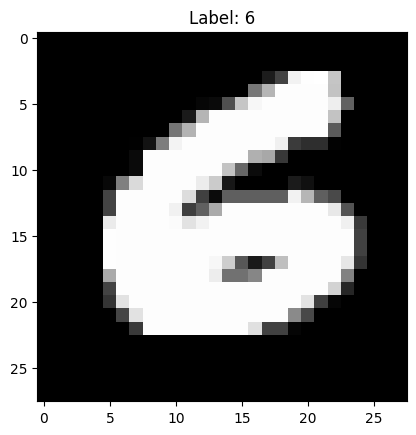

In [7]:
import matplotlib.pyplot as plt

x = x.to("cpu")

plt.title(f"Label: {y[0]}")
plt.imshow(x.squeeze()[0], cmap="gray")

plt.show()

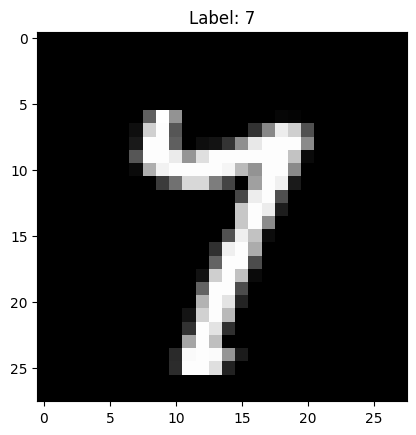

In [8]:
x = x.to("cpu")

plt.title(f"Label: {y[1]}")
plt.imshow(x.squeeze()[1], cmap="gray")

plt.show()

# Model Definition

TODO
- input norm
- batch norm
- hyperparameter tuning
- quantization

In [9]:
import torch
import torch.nn as nn

@torch.compile
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(1, -1) # (B, 28, 28) -> (B, 28*28)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        f = self.flatten(x)
        logits = self.linear_relu_stack(f)
        return logits

In [10]:
model = MLP()

model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [11]:
logits = model(x)

logits.shape

torch.Size([8, 10])

In [12]:
logits.argmax(1)

tensor([8, 0, 7, 0, 0, 0, 0, 0])

# Base Training

In [27]:
EPOCHS = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def train_loop(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer) -> float:
    model = model.to(device).train()
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.squeeze()

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (
            (pred.argmax(1) == y)
            .type(torch.float)
            .sum()
            .item()
        )

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    accuracy = correct / size
    train_loss /= size

    print(f"Train Error: \n Accuracy: {100 * accuracy:>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return accuracy

@torch.no_grad
def test_loop(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module) -> float:
    model = model.to(device).eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        X = X.squeeze()

        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (
            (pred.argmax(1) == y)
            .type(torch.float)
            .sum()
            .item()
        )

    test_loss /= size
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {100 * accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
dev_dataloader = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False)

model = MLP()
# model.compile()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_accuracies = []
test_accuracies = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_accuracy = train_loop(model, train_dataloader, loss_fn, optimizer)
    test_accuracy = test_loop(model, dev_dataloader, loss_fn)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch 1
-------------------------------
loss: 2.297475  [    0/50000]
loss: 0.593739  [ 3200/50000]
loss: 0.262782  [ 6400/50000]
loss: 0.474719  [ 9600/50000]
loss: 0.273897  [12800/50000]
loss: 0.117026  [16000/50000]
loss: 0.229061  [19200/50000]
loss: 0.665019  [22400/50000]
loss: 0.815856  [25600/50000]
loss: 0.058037  [28800/50000]
loss: 0.103121  [32000/50000]
loss: 0.328588  [35200/50000]
loss: 0.126098  [38400/50000]
loss: 0.200472  [41600/50000]
loss: 0.484386  [44800/50000]
loss: 0.179215  [48000/50000]
Train Error: 
 Accuracy: 89.5%, Avg loss: 0.011565 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.006718 

Epoch 2
-------------------------------
loss: 0.208941  [    0/50000]
loss: 0.128430  [ 3200/50000]
loss: 0.091406  [ 6400/50000]
loss: 0.169882  [ 9600/50000]
loss: 0.211048  [12800/50000]
loss: 0.149919  [16000/50000]
loss: 0.388928  [19200/50000]
loss: 0.110249  [22400/50000]
loss: 0.392031  [25600/50000]
loss: 0.084779  [28800/50000]
loss: 0.188984  [32000/50000]
loss:

# Analysis

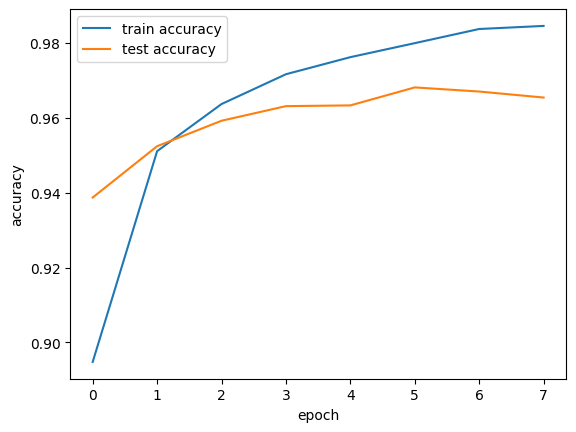

In [30]:
from matplotlib import pyplot as plt
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [32]:
print(f"Train accuracy: {train_accuracies[-1]*100:.4f}")
print(f"Test accuracy: {test_accuracies[-1]*100:.4f}")

Train accuracy: 98.4520
Test accuracy: 96.5400


Accuracy drop from train split to dev split is nearly ~2%. The model seems to be trending toward overfitting after the 5th epoch.

In [ ]:
# TODO: Let's graph the weights of the model to see if there is any pattern, graph weights to see how small/large they are in each layer